In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.initializers import RandomNormal, GlorotNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
print("TensorFlow version:",tf.__version__)
import numpy as np
from kerastuner.tuners import BayesianOptimization

TensorFlow version: 2.10.0


In [16]:
help(BayesianOptimization)

Help on class BayesianOptimization in module keras_tuner.tuners.bayesian:

class BayesianOptimization(keras_tuner.engine.tuner.Tuner)
 |  BayesianOptimization(hypermodel=None, objective=None, max_trials=10, num_initial_points=None, alpha=0.0001, beta=2.6, seed=None, hyperparameters=None, tune_new_entries=True, allow_new_entries=True, max_retries_per_trial=0, max_consecutive_failed_trials=3, **kwargs)
 |  
 |  BayesianOptimization tuning with Gaussian process.
 |  
 |  Args:
 |      hypermodel: Instance of `HyperModel` class (or callable that takes
 |          hyperparameters and returns a `Model` instance). It is optional
 |          when `Tuner.run_trial()` is overriden and does not use
 |          `self.hypermodel`.
 |      objective: A string, `keras_tuner.Objective` instance, or a list of
 |          `keras_tuner.Objective`s and strings. If a string, the direction of
 |          the optimization (min or max) will be inferred. If a list of
 |          `keras_tuner.Objective`, we wil

### Test envirement

In [17]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [18]:
tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)



Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0


In [19]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17840601757068976658
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3643801600
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1043382118857638562
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [20]:
tf.random.set_seed(5);
a = tf.random.normal([10000,2], 0, 1, tf.float32, seed=1)
b = tf.random.normal([2,10000], 0, 1, tf.float32, seed=1)
c = tf.matmul(a, b)


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0


### Model Construct

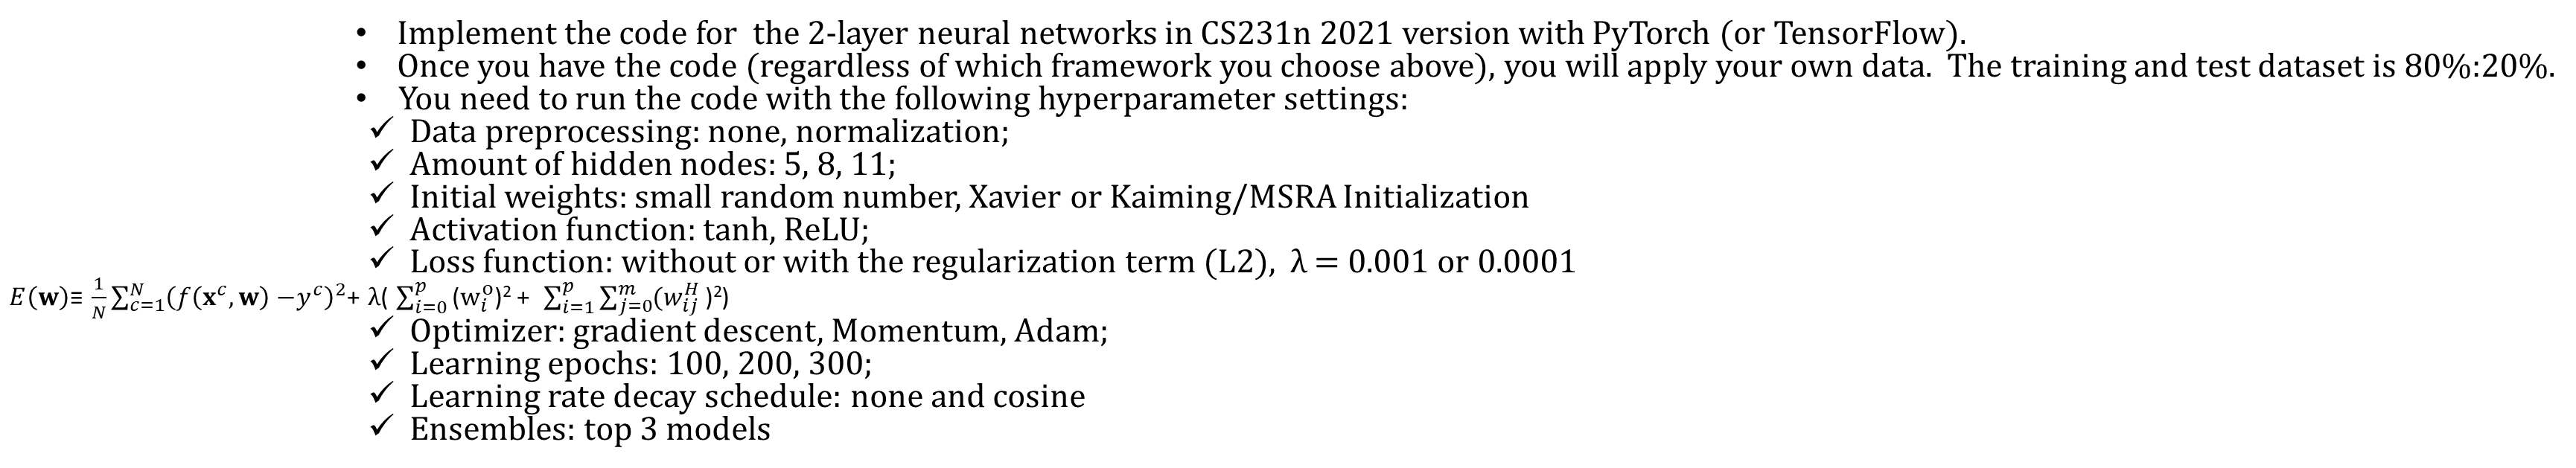

In [21]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

NameError: name 'model_builder' is not defined

In [ ]:
activation_fn = ['tanh','relu']
hidden_node = [5,8,11]
init_weight = ['small random number','Xavier','Kaiming','MSRA']
optimizer_type = [SGD(lr=0.01), SGD(lr=0.01, momentum=0.9), Adam(lr=0.01)]
learning_epochs = [100,200,300]
learning_decay_schedule = ['none','cosine']
loss_functions = ['categorical_crossentropy', 'mean_squared_error']
regularization_coefficients = [0.001, 0.0001]
num_class = 10
data_preprocessing = True
num_ensembles = 3
 

c:\Users\johnn\anaconda3\envs\tf_2.3_py_3.7\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
c:\Users\johnn\anaconda3\envs\tf_2.3_py_3.7\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### define model

In [ ]:
class MyModel(Model ):
    def __init__(self,activation_fn,hidden_node,init_weight,
                 optimizer_type,regularization_coefficients,
                 num_class):
        super(MyModel,self).__init__()
        self.activation_fn = activation_fn
        self.hidden_node = hidden_node
        self.init_weight = init_weight
        self.optimizer_type = optimizer_type
        self.regularizaton_coefficients = regularization_coefficients
        self.num_class = num_class

    def forward(self,inputs):
        out = self.flatten_layer(inputs)
        out = self.hidden_layer(out)
        out = self.output_layer(out)
        return out
    
def model_build(hp):
    activation_fn = hp.Choice('activation_fn',values = ['tanh','relu'])
    hidden_node = hp.Choice('hidden_node',values = [5,8,11])
    init_weight = hp.Choice('init_weight',values = ['random_normal','glorot_uniform','he_uniform'])
    optimizer_type = hp.Choice('optimizer_type',values = ['SGD', 'Adam', 'Momenton'] )
    regularization_coefficients = hp.Choice()
        

In [ ]:
a = MyModel.fit(data)

NameError: name 'data' is not defined

### Create a TensorFlow device context to use a GPU

In [ ]:
device_name = tf.test.gpu_device_name()
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected.")
else:
    print('GPU Device:', device_name)

GPU Device: /device:GPU:0


### load MNIST Data

In [ ]:
with tf.device(device_name):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    # Preprocess the data(N:normalize)
    x_train_N = x_train.astype('float32') / 255.0
    x_train = x_train.astype('float32')
    x_test_N = x_test.astype('float32') / 255.0
    x_test = x_test.astype('float32')
    x_train_N = x_train.reshape(x_train.shape[0], -1)
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test_N = x_test.reshape(x_test.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)
    y_train = tf.one_hot(y_train, depth=10)
    y_test = tf.one_hot(y_test, depth=10)

    # Create TensorFlow datasets
    BATCH_SIZE = 64
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)
    train_N_dataset = tf.data.Dataset.from_tensor_slices((x_train_N, y_train))
    train_N_dataset = train_N_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    test_dataset = test_dataset.batch(BATCH_SIZE)

    
    # Train the neural network using different hyperparameter settings
    for activation_function in activation_fn:
        for weight_initializer in init_weight:
            for loss_function in loss_functions:
                for regularization_coefficient in regularization_coefficients:
                    for optimizer in optimizer_type:
                        for learning_epoch in learning_epochs:
                            for hidden_nodes in hidden_node:
                                for learning_rate_decay_schedule in learning_rate_decay_schedules:
                                    print("Training model with activation function {}, weight initializer {}, loss function {}, regularization coefficient {}, optimizer {}, num epochs {}, num hidden nodes {}, learning rate decay schedule {}".format(
                                        activation_function, weight_initializer, loss_function, regularization_coefficient, optimizer.__class__.__name__, learning_epoch, hidden_nodes, learning_rate_decay_schedule))
                                    val_accs = []
                                    for ensemble_idx in range(num_ensembles):
                                        # Build the model
                                        model = build_model(num_hidden_nodes=hidden_nodes, activation_function=activation_function, weight_initializer=weight_initializer, loss_function=loss_function, regularization_coefficient=regularization_coefficient, optimizer=optimizer)
                                        
                                        # Define the learning rate decay schedule
                                        if learning_rate_decay_schedule is not None:
                                            if learning_rate_decay_schedule == 'cosine':
                                                def cosine_decay(epoch):
                                                    return 0.5 * (1 + np.cos((epoch * np.pi) / learning_epoch))
                                                lr_scheduler = LearningRateScheduler(cosine_decay)
                                            else:
                                                raise ValueError("Unknown learning")


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OneHot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OneHot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op SelectV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DummySeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV3 in device /job:localho

NameError: name 'activation_functions' is not defined

In [ ]:
# Normalize the pixel values
x_train_normal = x_train.astype('float32') / 255.0
x_test_normal = x_test.astype('float32') / 255.0

In [ ]:
# Create the model and optimizer
    model = MyModel()
    optimizer_adam = tf.keras.optimizers.Adam()
    optimizer_sdg = tf.keras.optimizers.SGD()
    optimizer_momenton = tf.keras.optimizers.SGD(momentum=1e-2)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess data
x_train = x_train.reshape(x_train.shape[0], 784).astype('float32') / 255.0
x_test = x_test.reshape(x_test.shape[0], 784).astype('float32') / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Define hyperparameters
learning_rate = 0.1
num_epochs = 300
batch_size = 128
num_hidden_nodes = 11
reg_lambda = 0.001
activation_fn = tf.nn.relu
weight_initializer = tf.initializers.GlorotUniform()

# Define model
class TwoLayerNN(tf.keras.Model):
    def __init__(self, num_hidden_nodes):
        super(TwoLayerNN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(num_hidden_nodes, activation=activation_fn,
                                            kernel_initializer=weight_initializer)
        self.dense2 = tf.keras.layers.Dense(10, kernel_initializer=weight_initializer)
    
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return x

# Create model instance
model = TwoLayerNN(num_hidden_nodes)

# Define loss function and optimizer
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Define train and test datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(60000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

# Training loop
train_loss_results = []
train_accuracy_results = []
test_loss_results = []
test_accuracy_results = []

for epoch in range(num_epochs):
    # Training
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
    for x, y in train_dataset:
        with tf.device('/GPU:0'): # Use GPU for training
            # Forward pass
            logits = model(x)
            # Compute loss
            loss_value = loss_fn(y, logits)
            # Add regularization term to loss
            l2_loss = sum(model.losses)
            loss_value += reg_lambda * l2_loss
            # Compute gradients
            gradients = tf.GradientTape(loss_value, model.trainable_variables)
            # Update weights
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            # Update metrics
            epoch_loss_avg.update_state(loss_value)
            epoch_accuracy.update_state(y, logits)
    
    # Save results for current epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    # Testing
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
    for x, y in test_dataset:
        with tf.device('/GPU:0'): # Use GPU for testing
            # Forward pass
            logits = model(x)
            # Compute loss
            loss_value = loss_fn(y, logits)
            # Add regularization term to loss
            l2_loss = sum(model.losses)
            loss_value += reg_lambda * l2_loss
            # Update metrics
            epoch_loss_avg.update_state(loss_value)
            epoch_accuracy.update_state


c:\Users\johnn\anaconda3\envs\tf_2.3_py_3.7\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


TypeError: 'GradientTape' object is not iterable

In [ ]:
pip install -q -U keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [22]:
from model_bulid import MyModel

In [23]:
help(MyModel)

Help on class MyModel in module model_bulid:

class MyModel(keras.engine.training.Model)
 |  MyModel(activation_fn, hidden_node, init_weight, optimizer_type, regularization_coefficients, num_class)
 |  
 |  #construct model stucture
 |  
 |  Method resolution order:
 |      MyModel
 |      keras.engine.training.Model
 |      keras.engine.base_layer.Layer
 |      tensorflow.python.module.module.Module
 |      tensorflow.python.trackable.autotrackable.AutoTrackable
 |      tensorflow.python.trackable.base.Trackable
 |      keras.utils.version_utils.LayerVersionSelector
 |      keras.utils.version_utils.ModelVersionSelector
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, activation_fn, hidden_node, init_weight, optimizer_type, regularization_coefficients, num_class)
 |  
 |  call(self, inputs)
 |      Calls the model on new inputs and returns the outputs as tensors.
 |      
 |      In this case `call()` just reapplies
 |      all ops in the graph to the new

In [24]:
from model_bulid import build_model

In [26]:
build_model.to_device()

AttributeError: 'function' object has no attribute 'to_device'

In [7]:
from kerastuner.tuners import BayesianOptimization
from model_bulid import build_model

In [8]:
turner = BayesianOptimization(build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='helloworld')

KeyboardInterrupt: 